# PowerPoint to Narrative-Aware Voiceover Transcript Generator

This notebook demonstrates the complete workflow for converting PowerPoint presentations into AI-generated voiceover transcripts using the unified transcript processor with Llama 4 Maverick through the Llama API.

## Overview

This unified workflow performs the following operations:

1. **Content Extraction**: Pulls speaker notes and visual elements from PowerPoint slides
2. **Image Conversion**: Transforms slides into high-quality images for AI analysis
3. **Flexible Processing**: Choose between standard or narrative-aware processing modes
4. **Transcript Generation**: Creates natural-sounding voiceover content with optional narrative continuity
5. **Speech Optimization**: Converts numbers, technical terms, and abbreviations to spoken form
6. **Results Export**: Saves transcripts and context information in multiple formats

## Key Features

- **Unified Processor**: Single class handles both standard and narrative-aware processing
- **Configurable Context**: Adjustable context window for narrative continuity
- **Mode Selection**: Toggle between standard and narrative processing with a simple flag
- **Backward Compatibility**: Maintains compatibility with existing workflows

## Prerequisites

Before running this notebook, ensure you have:
- Created a `.env` file with your `LLAMA_API_KEY`
- Updated `config.yaml` with your presentation file path
---

## Setup and Configuration

Import required libraries and load environment configuration.

In [54]:
# Import required libraries
import pandas as pd
import os
from pathlib import Path
from dotenv import load_dotenv
import matplotlib.pyplot as plt
from IPython.display import display

# Load environment variables from .env file
load_dotenv()

# Verify setup
if os.getenv('GROQ_API_KEY'):
    print("SUCCESS: Environment loaded successfully!")
    print("SUCCESS: GROQ API key found")
else:
    print("WARNING: GROQ_API_KEY not found in .env file")
    print("Please check your .env file and add your API key")

SUCCESS: Environment loaded successfully!
SUCCESS: GROQ API key found


In [55]:
# Import custom modules
try:
    from src.core.pptx_processor import extract_pptx_notes, pptx_to_images_and_notes
    from src.processors.unified_transcript_generator import (
        UnifiedTranscriptProcessor,
        process_slides,
        process_slides_with_narrative
    )
    from src.config.settings import load_config, get_config
    from src.utils.visualization import display_slide_grid, display_slide_preview


    print("SUCCESS: All modules imported successfully!")
    print("- PPTX processor ready")
    print("- Unified transcript generator ready")
    print("- Configuration manager ready")
    print("- Visualization generator ready")

except ImportError as e:
    print(f"ERROR: Import error: {e}")
    print("Make sure you're running from the project root directory")

SUCCESS: All modules imported successfully!
- PPTX processor ready
- Unified transcript generator ready
- Configuration manager ready
- Visualization generator ready


In [56]:
# Load and display configuration
config = load_config()
print("SUCCESS: Configuration loaded successfully!")
print("\nCurrent Settings:")
print(f"- Llama Model: {config['api']['groq_model']}")
print(f"- Image DPI: {config['processing']['default_dpi']}")
print(f"- Image Format: {config['processing']['default_format']}")
print(f"- Context Window: 5 previous slides (default)")

SUCCESS: Configuration loaded successfully!

Current Settings:
- Llama Model: meta-llama/llama-4-maverick-17b-128e-instruct
- Image DPI: 200
- Image Format: png
- Context Window: 5 previous slides (default)


#### Don't forget to update the config file with your pptx file name!

In [57]:
# Configure file paths from config.yaml
pptx_file = config['current_project']['pptx_file'] + config['current_project']['extension']
output_dir = config['current_project']['output_dir']

print("File Configuration:")
print(f"- Input File: {pptx_file}")
print(f"- Output Directory: {output_dir}")

# Verify input file exists
if Path(pptx_file).exists():
    file_size = Path(pptx_file).stat().st_size / 1024 / 1024
    print(f"- SUCCESS: Input file found ({file_size:.1f} MB)")
else:
    print(f"- ERROR: Input file not found: {pptx_file}")
    print("  Please update the 'pptx_file' path in config.yaml")

# Create output directory if needed
Path(output_dir).mkdir(parents=True, exist_ok=True)
print(f"- SUCCESS: Output directory ready")

File Configuration:
- Input File: input/All About Llamas.pptx
- Output Directory: output/
- SUCCESS: Input file found (10.8 MB)
- SUCCESS: Output directory ready


## Processing Mode Configuration

Choose your processing mode and configure the unified processor.

In [58]:
# Configure processing mode

USE_NARRATIVE = True  # Set to False for standard processing, True for narrative continuity
CONTEXT_WINDOW_SIZE = 5  # Number of previous slides to use as context (only used when USE_NARRATIVE=True)

print("Processing Mode Configuration:")
if USE_NARRATIVE:
    print(f"- Mode: NARRATIVE CONTINUITY")
    print(f"- Context Window: {CONTEXT_WINDOW_SIZE} previous slides")
else:
    print(f"- Mode: STANDARD PROCESSING")
    print(f"- Features: Independent slide processing, faster execution")

# Initialize the unified processor
processor = UnifiedTranscriptProcessor(
    use_narrative=USE_NARRATIVE,
    context_window_size=CONTEXT_WINDOW_SIZE
)

Processing Mode Configuration:
- Mode: NARRATIVE CONTINUITY
- Context Window: 5 previous slides



## Processing Pipeline

Execute the main processing pipeline in three key steps.

### Step 1: Extract Content and Convert to Images

Extract speaker notes and slide text, then convert the presentation to high-quality images for AI analysis.

PROCESSING: Converting PPTX to images and extracting notes...
Processing: All About Llamas.pptx
Extracting speaker notes...
Found notes on 10 of 10 slides
Notes df saved to: /Users/yucedincer/Desktop/Projects/llama-cookbook/end-to-end-use-cases/powerpoint-to-voiceover-transcript/output/All About Llamas_notes.csv
Converting to PDF...
Converting to PNG images at 200 DPI...

Successfully processed 10 slides
Images saved to: /Users/yucedincer/Desktop/Projects/llama-cookbook/end-to-end-use-cases/powerpoint-to-voiceover-transcript/output

SUCCESS: Processing completed successfully!
- Processed 10 slides
- Images saved to: /Users/yucedincer/Desktop/Projects/llama-cookbook/end-to-end-use-cases/powerpoint-to-voiceover-transcript/output
- Found notes on 10 slides
- DataFrame shape: (10, 8)

Sample Data (First 5 slides):


,slide_number,slide_title,has_notes,notes_word_count,slide_text_word_count
0,1,Llamas: Fascinating Animals of the Andes,True,34,14
1,2,Introduction to Llamas,True,28,25
2,3,Physical Characteristics,True,28,33
3,4,Diet & Habitat,True,24,23
4,5,Behavior & Social Structure,True,31,30



Displaying first 6 of 10 slide images:


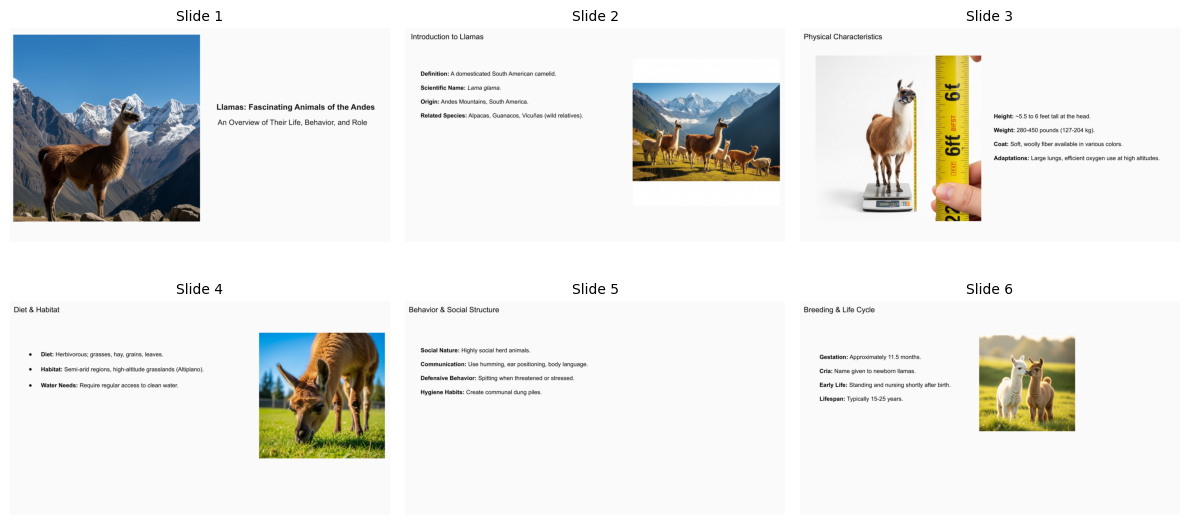

In [43]:
print("PROCESSING: Converting PPTX to images and extracting notes...")

result = pptx_to_images_and_notes(
    pptx_path=pptx_file,
    output_dir=output_dir,
    extract_notes=True
)

notes_df = result['notes_df']
image_files = result['image_files']

print(f"\nSUCCESS: Processing completed successfully!")
print(f"- Processed {len(image_files)} slides")
print(f"- Images saved to: {result['output_dir']}")
print(f"- Found notes on {notes_df['has_notes'].sum()} slides")
print(f"- DataFrame shape: {notes_df.shape}")

# Show sample data

print("\nSample Data (First 5 slides):")
display(notes_df[['slide_number', 'slide_title', 'has_notes', 'notes_word_count', 'slide_text_word_count']].head())

# Preview only the first 6 slide images
display_slide_preview(image_files, num_slides=6, max_cols=3)

### Step 2: Generate Narrative-Aware AI Transcripts

Use the Llama vision model to analyze each slide image and generate natural-sounding voiceover transcripts with narrative continuity.

This process:
- Analyzes slide visual content using AI vision
- Uses transcripts from previous slides as context
- Combines slide content with speaker notes
- Generates speech-optimized transcripts with smooth transitions
- Maintains consistent terminology throughout the presentation
- Converts numbers and technical terms to spoken form

In [44]:
print("PROCESSING: Starting AI transcript generation with unified processor...")
print(f"- Processing {len(notes_df)} slides")
print(f"- Using model: {config['api']['llama_model']}")
print(f"- Mode: {'Narrative Continuity' if USE_NARRATIVE else 'Standard Processing'}")
if USE_NARRATIVE:
    print(f"- Context window: {CONTEXT_WINDOW_SIZE} previous slides")
    print(f"- Using previous transcripts as context for narrative continuity")
print("- This may take several minutes...")

# Generate transcripts using the unified processor
processed_df = processor.process_slides_dataframe(
    df=notes_df,
    output_dir=output_dir,
    save_context=True  # Only saves context if USE_NARRATIVE=True
)

print(f"\nSUCCESS: Transcript generation completed!")
print(f"- Generated {len(processed_df)} transcripts")
print(f"- Average length: {processed_df['ai_transcript'].str.len().mean():.0f} characters")
print(f"- Total words: {processed_df['ai_transcript'].str.split().str.len().sum():,}")

if USE_NARRATIVE:
    print(f"- Context information saved to: {output_dir}narrative_context/")
    print(f"- Average context slides used: {processed_df['context_slides_used'].mean():.1f}")

PROCESSING: Starting AI transcript generation with unified processor...
- Processing 10 slides
- Using model: Llama-4-Maverick-17B-128E-Instruct-FP8
- Mode: Narrative Continuity
- Context window: 5 previous slides
- Using previous transcripts as context for narrative continuity
- This may take several minutes...
Processing 10 slides with narrative continuity...
Using context window of 5 previous slides


Processing slides: 100%|████████████████████████| 10/10 [00:30<00:00,  3.01s/it]

Context information saved to: output/narrative_context

SUCCESS: Transcript generation completed!
- Generated 10 transcripts
- Average length: 541 characters
- Total words: 767
- Context information saved to: output/narrative_context/
- Average context slides used: 3.5


In [48]:
print('Displaying first 10 slide transcripts\n')
for idx, row in processed_df.head(10).iterrows():
    print('Slide', row['slide_number'])
    print(row['ai_transcript'])
    print()

Displaying first 10 slide transcripts

Slide 1
Llamas are unique animals deeply intertwined with human history and culture in the Andes Mountains of South America. They're fascinating creatures that have adapted to the harsh, high-altitude environments of the Andes. Today, we're going to explore their life, behavior, and the significant role they play in their native habitats. Let's discover why they're so remarkable.

Slide 2
A domesticated South American camelid, scientifically known as Lama glama, originates from the Andes Mountains in South America. Related species include alpacas, guanacos, and vicuñas, which are their wild relatives. Llamas were domesticated thousands of years ago, descending from wild camelids native to South America, and share their habitat with these related species.

Slide 3
Llamas typically stand between five point five to six feet tall at the head and weigh between two hundred eighty and four hundred fifty pounds, or one hundred twenty-seven to two hundred 

### Step 3: Save Results

Save results in multiple formats for different use cases.

In [46]:
print("PROCESSING: Saving results in multiple formats...")

# Create output directory
os.makedirs(output_dir, exist_ok=True)

# Determine file prefix based on processing mode
file_prefix = "narrative" if USE_NARRATIVE else "standard"

# Save complete results with all metadata
output_file = f"{output_dir}{file_prefix}_transcripts.csv"
processed_df.to_csv(output_file, index=False)
print(f"- SUCCESS: Complete results saved to {output_file}")

# Save transcript-only version for voiceover work
if USE_NARRATIVE:
    transcript_only = processed_df[['slide_number', 'slide_title', 'ai_transcript', 'context_slides_used']]
else:
    transcript_only = processed_df[['slide_number', 'slide_title', 'ai_transcript']]

transcript_file = f"{output_dir}{file_prefix}_transcripts_clean.csv"
transcript_only.to_csv(transcript_file, index=False)
print(f"- SUCCESS: Clean transcripts saved to {transcript_file}")

# Save as JSON for API integration
json_file = f"{output_dir}{file_prefix}_transcripts.json"
processed_df.to_json(json_file, orient='records', indent=2)
print(f"- SUCCESS: JSON format saved to {json_file}")

# Summary statistics
total_words = processed_df['ai_transcript'].str.split().str.len().sum()
reading_time = total_words / 150  # Assuming 150 words per minute

print(f"\nExport Summary:")
print(f"- Processing mode: {'Narrative Continuity' if USE_NARRATIVE else 'Standard Processing'}")
print(f"- Total slides processed: {len(processed_df)}")
print(f"- Slides with speaker notes: {processed_df['has_notes'].sum()}")
print(f"- Total transcript words: {total_words:,}")
print(f"- Average transcript length: {processed_df['ai_transcript'].str.len().mean():.0f} characters")
print(f"- Estimated reading time: {reading_time:.1f} minutes")

if USE_NARRATIVE and 'context_slides_used' in processed_df.columns:
    print(f"- Average context slides per slide: {processed_df['context_slides_used'].mean():.1f}")

PROCESSING: Saving results in multiple formats...
- SUCCESS: Complete results saved to output/narrative_transcripts.csv
- SUCCESS: Clean transcripts saved to output/narrative_transcripts_clean.csv
- SUCCESS: JSON format saved to output/narrative_transcripts.json

Export Summary:
- Processing mode: Narrative Continuity
- Total slides processed: 10
- Slides with speaker notes: 10
- Total transcript words: 767
- Average transcript length: 541 characters
- Estimated reading time: 5.1 minutes
- Average context slides per slide: 3.5


---
# Completion Summary

## Successfully Generated:
- **Unified Processing**: Single processor handles both standard and narrative modes
- **Flexible Configuration**: Easy switching between processing modes
- **Speech-Optimized Transcripts**: Natural-sounding voiceover content
- **Multiple Formats**: CSV, JSON exports for different use cases
- **Context Analysis**: Detailed information about narrative flow (when enabled)

## Output Files:
- `[mode]_transcripts.csv` - Complete dataset with metadata
- `[mode]_transcripts_clean.csv` - Clean transcripts for voiceover work
- `[mode]_transcripts.json` - JSON format for API integration
- `narrative_context/` - Context analysis files (narrative mode only)
- Individual slide images in PNG/JPEG format

## Processing Modes:

### Standard Mode (`USE_NARRATIVE = False`)
- **Best for**: Simple presentations, quick processing, independent slides
- **Features**: Fast execution, no context dependencies
- **Use cases**: Training materials, product demos, standalone slides

### Narrative Mode (`USE_NARRATIVE = True`)
- **Best for**: Story-driven presentations, complex topics, educational content
- **Features**: Context awareness, smooth transitions, terminology consistency
- **Use cases**: Conference talks, educational courses, marketing presentations

## Next Steps:
1. **Review** generated transcripts for accuracy and flow
2. **Edit** any content that needs refinement
3. **Create** voiceover recordings or use TTS systems
4. **Integrate** JSON data into your video production workflow
5. **Experiment** with different processing modes for optimal results

## Tips for Better Results:
- **Rich Speaker Notes**: Detailed notes improve transcript quality in both modes
- **Clear Visuals**: High-contrast slides with readable text work best
- **Mode Selection**: Use narrative mode for complex presentations, standard for simple ones
- **Context Window**: Adjust context window size (3-7 slides) based on presentation complexity
- **Consistent Style**: Maintain consistent formatting across your presentation

---